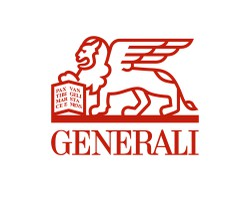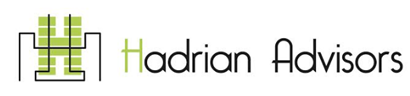

# Insurance usecase


# Building a KERAS model  <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> 

The aim of that notebook is to build a robust neural network model, using the KERAS library, by selecting the right number of layers along with the right activation function for each layer.

The model will be implemented on our insurance usecase; we are trying to predict the cost of each customer, using the ratio between their risk premiums and their premiums.



## 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn
import gc
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
import time

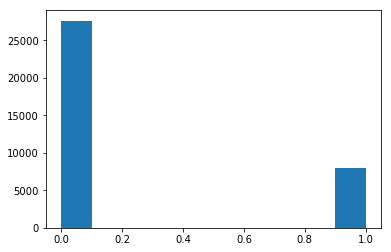

In [3]:
# read datasets
pathData = 'data/'

train = pd.read_csv(pathData+'trainDataset.csv')
Y = train['target'].as_matrix()
DF_X = train.drop('target',axis=1)

test =  pd.read_csv(pathData+'testDataset.csv')
Y_test = test['target'].as_matrix()
DF_X_test = test.drop('target',axis=1)

# right type
for c in DF_X.columns:
    if 'Cat_' in c:
        DF_X[c] = DF_X[c].astype(str)
        DF_X_test[c] = DF_X_test[c].astype(str)
    else:
        DF_X[c] = DF_X[c].astype(float)
        DF_X_test[c] = DF_X_test[c].astype(float)

# Categorization
treshold_ExLR = 0.7

Id_0_train = np.nonzero(Y<treshold_ExLR)[0]
Id_0_test = np.nonzero(Y_test<treshold_ExLR)[0]

Id_1_train = np.nonzero(Y>=treshold_ExLR)[0]
Id_1_test = np.nonzero(Y_test>=treshold_ExLR)[0]

Y[Id_0_train] = 0
Y[Id_1_train] = 1

Y_test[Id_0_test] = 0
Y_test[Id_1_test] = 1


# Encode categorical variables
DF_X = DF_X.copy()
DF_X_test = DF_X_test.copy()
for var in DF_X.columns:
    if str(DF_X[var].dtypes)=='object':
        le = LabelEncoder().fit(DF_X[var])
        DF_X[var] = le.transform(DF_X[var])
        DF_X_test[var] = le.transform(DF_X_test[var])
        
plt.hist(Y)
plt.show()

In [4]:
# Var importance using RF classifier
st = time.time()
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(random_state=0, n_estimators=100,\
                                  criterion='gini',max_depth=5)
VarImp = estimator.fit(DF_X,Y).feature_importances_
VarToUse = np.array(DF_X.columns.tolist())[np.argsort(-VarImp)[:5]]
print(VarToUse)
print('')
print('cell running time = ' + str(round(time.time()-st,2)))

['NumInsurance13' 'Cat_Insurance4' 'Num_Car11' 'NumInsurance11'
 'Cat_Insurance3']

cell running time = 3.33


---------------------------------------------------

## KERAS Modelling

In [5]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


ImportError: No module named 'tensorflow'

In [ ]:
# Sampling
IdRand = np.sort(np.random.permutation(np.arange(len(Y)))[:5000])
X_sample = DF_X[VarToUse].as_matrix()[IdRand]
Y_sample = Y[IdRand]

# Params for randomGridSearch
nbCombinations = 4
nbCV = 4

# Normalization
normX = MinMaxScaler()
normX.fit(X_sample)
X_sample_norm = normX.transform(X_sample)

### Grid search on activation function
#### Activation function on first on last layer: 
we assume that the first layer contain N_Var neurons and the last layer contains 1 neuron

In [ ]:
# Randomized on first and layer activation function
def DL_model_0(firstLayerActivation,lastLayerActivation):
    # create model
    model = Sequential()
    
    # Input layer with N_Neurons=Cols(X)
    model.add(Dense(X_sample.shape[1],input_dim=X_sample.shape[1],\
                    kernel_initializer='normal',\
                    activation=firstLayerActivation))
    
    # Output layer with N_Neurons = 1
    model.add(Dense(1, input_dim=X_sample.shape[1],kernel_initializer='normal',\
                    activation=lastLayerActivation))
    
    # Compile model with stochastic gradient descent optimizer
    model.compile(loss='binary_crossentropy',\
                  optimizer=Adam(lr=.1), metrics=['accuracy'])
    return model

# Use keras model into Randomized grid search (scikit)
model_0 = KerasClassifier(build_fn=DL_model_0, verbose=0,epochs=10)

We want to select the best activation function for these layers. To do so, we can use the functions implemented in scikit-learn; for example, **RandomizedSearchCV** can be useful.

In [ ]:
model = DL_model_0('tanh','sigmoid')
model.fit(X_sample_norm,Y_sample.reshape(len(Y_sample),1),epochs=10)

In [ ]:
from sklearn.model_selection import train_test_split
XL,_,YL,_ = train_test_split(X_sample_norm,Y_sample,test_size=int(0.2*len(X_sample_norm)))

st = time.time()
ListActivationFunction = ['tanh','relu','sigmoid','softmax']
param_grid = dict(firstLayerActivation=ListActivationFunction,
                 lastLayerActivation=ListActivationFunction)
grid = RandomizedSearchCV(estimator=model_0,param_distributions=param_grid,
                    n_iter=nbCombinations,cv=nbCV,scoring='f1_weighted')
grid_result_0 = grid.fit(XL,YL)
print(grid_result_0.best_params_)
print(grid_result_0.best_score_)
print('cell running time = ' + str(round(time.time()-st,2)))

### Hidden Layer Grid search
let's add the hidden layer one by one, the grid search will be on 
the nb_of neurons and the activation function for this layer.

In this part a dropout regularization is added to limit the overfitting

In [ ]:
# We use the parameters for the first and last layers found above
firstLayerActivation = grid_result_0.best_params_['firstLayerActivation']
lastLayerActivation = grid_result_0.best_params_['lastLayerActivation']

from keras.layers import Dropout

def DL_model_1(nbNeurons_H1,
               activation_H1,dropout_rate_H1,lastLayerActivation):
    # create model
    model = Sequential()
    
    # First Hidden layer parameters
    model.add(Dense(nbNeurons_H1,input_dim=X_sample.shape[1],
                    activation=activation_H1))
    model.add(Dropout(dropout_rate_H1))
    #--------------------------------------
    
    model.add(Dense(1, kernel_initializer='normal',\
                    activation=lastLayerActivation))
    # Compile model
    model.compile(loss='binary_crossentropy',\
                  optimizer=SGD(lr=.1,momentum=0.), metrics=['accuracy'])
    return model

model_1 = KerasClassifier(build_fn=DL_model_1, verbose=0,epochs=10)

In [ ]:
from sklearn.model_selection import train_test_split
XL,_,YL,_ = train_test_split(X_sample_norm,Y_sample,test_size=int(0.2*len(X_sample_norm)))

st = time.time()
param_grid_1 = dict(activation_H1=ListActivationFunction,\
                    nbNeurons_H1=range(2,X_sample_norm.shape[1],2),\
                   dropout_rate_H1 = [0.,0.1,0.2,0.4,0.8],
                   lastLayerActivation = ListActivationFunction)

grid = RandomizedSearchCV(estimator=model_1,\
                          param_distributions=param_grid_1,\
                          n_iter=nbCombinations,\
                          cv=nbCV,\
                          scoring='f1_weighted')

grid_result_1 = grid.fit(XL,YL)

print(grid_result_1.best_params_)
print(grid_result_1.best_score_)
print('cell running time = ' + str(round(time.time()-st,2)))

### Second Hidden Layer

**Exercice** :

Build a two hidden layers neural network using the previous results for the first hidden layer.

In [ ]:
nbNeurons_H1 = grid_result_1.best_params_['nbNeurons_H1']
activation_H1 = grid_result_1.best_params_['activation_H1']
dropout_rate_H1 = grid_result_1.best_params_['dropout_rate_H1']
lastLayerActivation = grid_result_1.best_params_['lastLayerActivation']

def DL_model_2(nbNeurons_H2,
               activation_H2,dropout_rate_H2):
    # create model
    model = Sequential()
    
    ############ ENTER YOUR CODE HERE ###################
    # First layer
    model.add(Dense(nbNeurons_H1, input_dim=X_sample.shape[1], activation=activation_H1))
    model.add(Dropout(dropout_rate_H1))
    
    # Second layer
    model.add(Dense(nbNeurons_H2, activation=activation_H2))
    model.add(Dropout(dropout_rate_H2))
    
    ############ END OF THE CODE ################
    #--------------------------------------
    
    model.add(Dense(1, kernel_initializer='normal',\
                    activation=lastLayerActivation))
    # Compile model
    model.compile(loss='binary_crossentropy',\
                  optimizer='adam', metrics=['accuracy'])
    return model

model_2 = KerasClassifier(build_fn=DL_model_2, verbose=0,epochs=10)

In [ ]:
from sklearn.model_selection import train_test_split
XL,_,YL,_ = train_test_split(X_sample_norm,Y_sample,test_size=int(0.2*len(X_sample_norm)))

st = time.time()
param_grid_2 = dict(activation_H2=ListActivationFunction,\
                    nbNeurons_H2=range(2,X_sample_norm.shape[1],2),\
                   dropout_rate_H2 = [0.,0.1,0.2,0.4,0.8])

grid = RandomizedSearchCV(estimator=model_2,\
                          param_distributions=param_grid_2,\
                          n_iter=nbCombinations,\
                          cv=nbCV,\
                          scoring='f1_weighted')

grid_result_2 = grid.fit(XL,YL)
print(grid_result_2.best_params_)
print(grid_result_2.best_score_)
print('cell running time = ' + str(round(time.time()-st,2)))

In [ ]:
nbNeurons_H2 = grid_result_2.best_params_['nbNeurons_H2']
activation_H2 = grid_result_2.best_params_['activation_H2']
dropout_rate_H2 = grid_result_2.best_params_['dropout_rate_H2']


def DL_model_3(nbNeurons_H3,
               activation_H3,dropout_rate_H3):
    # create model
    model = Sequential()
    
    model.add(Dense(nbNeurons_H1,input_dim=X_sample.shape[1],activation=activation_H1))
    model.add(Dropout(dropout_rate_H1))

    model.add(Dense(nbNeurons_H2,activation=activation_H2))
    model.add(Dropout(dropout_rate_H3))
    
    # Third Hidden layer parmeters
    model.add(Dense(nbNeurons_H3,activation=activation_H3))
    model.add(Dropout(dropout_rate_H3))
    #--------------------------------------
    
    model.add(Dense(1, kernel_initializer='normal',\
                    activation=lastLayerActivation))
    # Compile model
    model.compile(loss='binary_crossentropy',\
                  optimizer='adam', metrics=['accuracy'])
    return model

model_3 = KerasClassifier(build_fn=DL_model_3, verbose=0,epochs=10)

In [ ]:
from sklearn.model_selection import train_test_split
XL,_,YL,_ = train_test_split(X_sample_norm,Y_sample,test_size=int(0.2*len(X_sample_norm)))

st = time.time()
param_grid_3 = dict(activation_H3=ListActivationFunction,\
                    nbNeurons_H3=range(2,X_sample_norm.shape[1],2),\
                   dropout_rate_H3 = [0.,0.2,0.4,0.6,0.8])

grid = RandomizedSearchCV(estimator=model_3,\
                          param_distributions=param_grid_3,\
                          n_iter=nbCombinations,\
                          cv=nbCV,\
                          scoring='f1_weighted')

grid_result_3 = grid.fit(XL,YL)
print(grid_result_3.best_params_)
print(grid_result_3.best_score_)
print('cell running time = ' + str(round(time.time()-st,2)))

Sometimes adding a new layer wont improve the model

In [ ]:
print('Auc CV after gridsearch 0 = '+ str(round(grid_result_0.best_score_,4)))
print('Auc CV after gridsearch 1 = '+ str(round(grid_result_1.best_score_,4)))
print('Auc CV after gridsearch 2 = '+ str(round(grid_result_2.best_score_,4)))
print('Auc CV after gridsearch 3 = '+ str(round(grid_result_3.best_score_,4)))

In [ ]:
nbNeurons_H3 = grid_result_3.best_params_['nbNeurons_H3']
activation_H3 = grid_result_3.best_params_['activation_H3']
dropout_rate_H3 = grid_result_3.best_params_['dropout_rate_H3']


# Final Model
model = Sequential()
    
model.add(Dense(nbNeurons_H1,input_dim=X_sample.shape[1],activation=activation_H1))
model.add(Dropout(dropout_rate_H1))

model.add(Dense(nbNeurons_H2,activation=activation_H2))
model.add(Dropout(dropout_rate_H2))

model.add(Dense(nbNeurons_H3,activation=activation_H3))
model.add(Dropout(dropout_rate_H3))

model.add(Dense(1, kernel_initializer='normal',\
                    activation=lastLayerActivation))
# Compile model
model.compile(loss='binary_crossentropy',\
                  optimizer=Adam(lr=.01), metrics=['accuracy'])



In [ ]:
model.fit(X_sample_norm,Y_sample.reshape(len(Y_sample),1),verbose=1,epochs=10)
# prediction on train sample
KerasPredTrain = model.predict(normX.transform(DF_X[VarToUse].as_matrix()))
KerasPredTrain = KerasPredTrain.reshape(Y.shape)

# prediction on test sample
KerasPredTest = model.predict(normX.transform(DF_X_test[VarToUse].as_matrix()))
KerasPredTest = KerasPredTest.reshape(Y_test.shape) 

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y,KerasPredTrain)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Train')
plt.legend(loc="lower right")
plt.show()


fpr_test, tpr_test, _ = roc_curve(\
                Y_test,KerasPredTest)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Test')
plt.legend(loc="lower right")
plt.show()


In [ ]:
KerasPredTest

## Batch size parameters

Batch size defines number of samples that going to be propagated through the network.

- Advantages:

It requires less memory. Since you train network using less number of samples the overall training procedure requires less memory. It's especially important in case if you are not able to fit dataset in memory.

Typically networks trains faster with mini-batches. That's because we update weights after each propagation. 

- Disadvantages:

The smaller the batch the less accurate estimate of the gradient. (batch_size=number of samples by gradient update)

In [ ]:
# Normalization
normX_All = MinMaxScaler()
normX_All.fit(DF_X[VarToUse].as_matrix())
X_Norm_train = normX_All.transform(DF_X[VarToUse].as_matrix())
X_Norm_test = normX_All.transform(DF_X_test[VarToUse].as_matrix())

In [ ]:
# Fit and predict
# Same model: learning on all the dataset using batch_size parameters
model = Sequential()
    
model.add(Dense(nbNeurons_H1,input_dim=X_sample.shape[1],activation=activation_H1))
model.add(Dropout(dropout_rate_H1))

model.add(Dense(nbNeurons_H2,activation=activation_H2))
model.add(Dropout(dropout_rate_H2))


model.add(Dense(1, kernel_initializer='normal',\
                    activation=lastLayerActivation))
# Compile model
model.compile(loss='binary_crossentropy',\
                  optimizer=Adam(lr=.01), metrics=['accuracy'])

model.fit(X_Norm_train,Y.reshape(len(Y),1),epochs=10,batch_size=100)

# prediction on train sample
KerasPredTrain = model.predict(X_Norm_train)
KerasPredTrain = KerasPredTrain.reshape(Y.shape)

# prediction on test sample
KerasPredTest = model.predict(X_Norm_test)
KerasPredTest = KerasPredTest.reshape(Y_test.shape) 

In [ ]:
fpr, tpr, _ = roc_curve(Y,KerasPredTrain)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Train')
plt.legend(loc="lower right")
plt.show()


fpr_test, tpr_test, _ = roc_curve(\
                Y_test,KerasPredTest)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on Test')
plt.legend(loc="lower right")
plt.show()